# Big Data final project.
##Authors:
 Nicolás Cárdenas Roig

 Alejandro Domínguez Rondón

 David García Valcarce

 Jacob González Isa


# DLlib installation

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#
# Install latest pre-release version of bigdl-dllib with spark3
# Find the latest bigdl-dllib with spark3 from https://sourceforge.net/projects/analytics-zoo/files/dllib-py-spark3/ and intall it
!pip install https://sourceforge.net/projects/analytics-zoo/files/dllib-py-spark3/bigdl_dllib_spark3-0.14.0b20211107-py3-none-manylinux1_x86_64.whl

exit() # restart the runtime to refresh installed pkg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 20.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880747 sha256=a661521cbcf6d8648e40c67792102563004d2bc3f52a15809fb1552bb01749c5
  Stored in directory: /root/.cache/pip/wheels/ef/70/50/7882e1bcb5693225f7cc86698f10953201b48b3f36317c2d18
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


# Imports

In [1]:
## Spark libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.functions import udf
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, ArrayType, DoubleType
from pyspark.sql.functions import col
from pyspark.ml.linalg import VectorUDT, Vectors


## BigDL libraries
from bigdl.dllib.nncontext import *
from bigdl.dllib.keras.layers import *
from bigdl.dllib.keras.models import *
#import bigdl.dllib.keras.Sequential
from bigdl.dllib.nnframes import *
from bigdl.dllib.nn.criterion import *

## To load the data from kaggle
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from functools import reduce

## To render images and plot whatever we may need
import matplotlib.pyplot as plt

## Init NNContext and create Spark session
sc = init_nncontext(cluster_mode="local") # run in local mode
spark = SparkSession(sc)

Prepending /usr/local/lib/python3.10/dist-packages/bigdl/share/dllib/conf/spark-bigdl.conf to sys.path
Current pyspark location is : /usr/local/lib/python3.10/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.10/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_3.1.2-0.14.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


# Dataset download

In [2]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/kaggle"

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Define the path to your zip file
file_path = '/content/chest-xray-pneumonia.zip'

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

100% 2.29G/2.29G [00:21<00:00, 199MB/s]
100% 2.29G/2.29G [00:21<00:00, 115MB/s]


# Image preprocessing

In order to increase the neural network efficiency, the images' pixel data is scaled down from a 0-255 range to a 0-1 range. Also, to reduce overfitting and create a more robust model, images are flipped upside down and left to right, to increase variability to the dataset.

Images are scaled down in size to 140 by 140 pixel square images, small enough to handle but big enough to still contain valuable data.

In [11]:
train_dir = "/content/chest_xray/train/"
val_dir = "/content/chest_xray/val/"
test_dir = "/content/chest_xray/test/"

In [38]:
#data transformation
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)


In [39]:
#data transformation
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)


train_dir = "/content/chest_xray/train/"
val_dir = "/content/chest_xray/val/"
test_dir = "/content/chest_xray/test/"
#import the data
train_generator= train_datagen.flow_from_directory(train_dir, target_size =(140,140), batch_size = 130 ,class_mode="binary", color_mode="rgb" )
validation_generator = validation_datagen.flow_from_directory(val_dir, target_size = (140,140), batch_size =  130, class_mode="binary",  color_mode="rgb" )
test_generator = test_datagen.flow_from_directory(test_dir, target_size = (140,140), batch_size= 130, class_mode="binary",  color_mode="rgb" )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Class indices for training data: {'NORMAL': 0, 'PNEUMONIA': 1}
Class indices for validation data: {'NORMAL': 0, 'PNEUMONIA': 1}
Class indices for test data: {'NORMAL': 0, 'PNEUMONIA': 1}
Number of observations for each class in training data: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Number of observations for each class in validation data: {'NORMAL': 8, 'PNEUMONIA': 8}
Number of observations for each class in test data: {'NORMAL': 234, 'PNEUMONIA': 390}


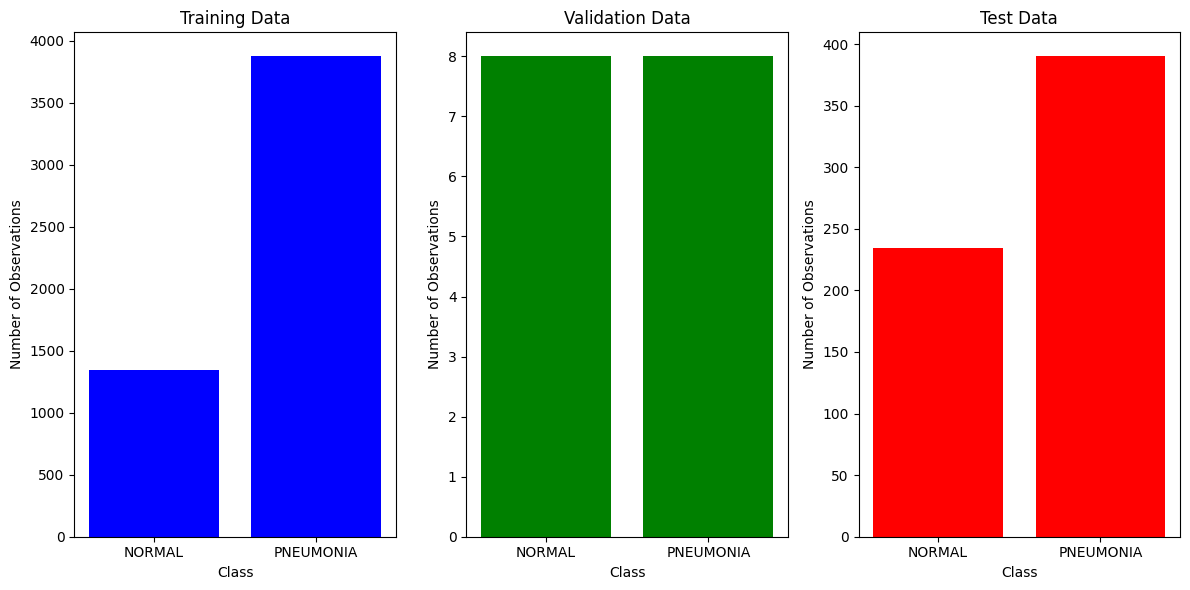

In [40]:
# Get the class indices from the generators
class_indices_train = train_generator.class_indices
class_indices_validation = validation_generator.class_indices
class_indices_test = test_generator.class_indices

# Print the class indices (class name -> class index)
print("Class indices for training data:", class_indices_train)
print("Class indices for validation data:", class_indices_validation)
print("Class indices for test data:", class_indices_test)

# Count the number of observations for each class
num_classes_train = {class_name: len(list(filter(lambda x: x == class_index, train_generator.classes))) for class_name, class_index in class_indices_train.items()}
num_classes_validation = {class_name: len(list(filter(lambda x: x == class_index, validation_generator.classes))) for class_name, class_index in class_indices_validation.items()}
num_classes_test = {class_name: len(list(filter(lambda x: x == class_index, test_generator.classes))) for class_name, class_index in class_indices_test.items()}

# Print the number of observations for each class
print("Number of observations for each class in training data:", num_classes_train)
print("Number of observations for each class in validation data:", num_classes_validation)
print("Number of observations for each class in test data:", num_classes_test)
import matplotlib.pyplot as plt

# Get the class names and counts
class_names_train = list(num_classes_train.keys())
class_counts_train = list(num_classes_train.values())

class_names_validation = list(num_classes_validation.keys())
class_counts_validation = list(num_classes_validation.values())

class_names_test = list(num_classes_test.keys())
class_counts_test = list(num_classes_test.values())

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.bar(class_names_train, class_counts_train, color='blue')
plt.title('Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Observations')

plt.subplot(1, 3, 2)
plt.bar(class_names_validation, class_counts_validation, color='green')
plt.title('Validation Data')
plt.xlabel('Class')
plt.ylabel('Number of Observations')

plt.subplot(1, 3, 3)
plt.bar(class_names_test, class_counts_test, color='red')
plt.title('Test Data')
plt.xlabel('Class')
plt.ylabel('Number of Observations')

plt.tight_layout()
plt.show()

Pneumonia-class images in the training set are more common than normal-class images. This will probably make the model more sensitive towards this class.

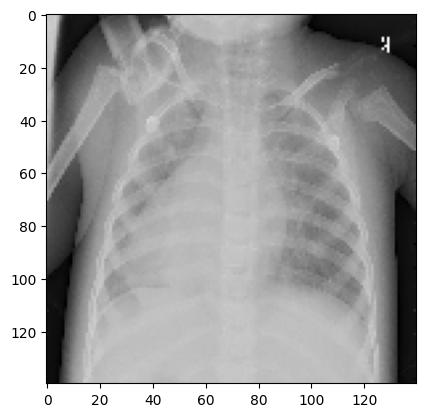

In [41]:
## Prueba para ver que las imagenes se han importado bien
import matplotlib.pyplot as plt

images, labels = next(train_generator)
plt.imshow(images[0])

Sample image: even after downsizing, the shapes and textures are still distinct, not a lot of information has been lost.

# Spark dataframe generation

Spark dataframes containing the image pixel data and label in the 'features' and 'label' columns will be used as inputs for the DLlib neural network classifier.

In [42]:
## Turn the result to a dataframe
images, labels = next(train_generator)

# Flatten the nested arrays in images and tur the labels into floats
flattened_images = [image.flatten().tolist() for image in images]
float_labels = [float(label) for label in labels]

# Combine images and labels into tuples
data = list(zip(flattened_images, float_labels))

# dataframe schema
schema = StructType([
    StructField("images", ArrayType(DoubleType()), True),
    StructField("label", DoubleType(), True)
])


df = spark.createDataFrame(data, schema=schema)
df = df.withColumn("label", col("label").cast(DoubleType()))
df.printSchema()

root
 |-- images: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- label: double (nullable = true)



In [43]:
## Turn the images column into a densevector
numpy_to_vector_udf = udf(lambda x: Vectors.dense(x), VectorUDT())

df_vec= df.withColumn("images", numpy_to_vector_udf("images"))

df_vec.printSchema()
df_vec.show(1)

root
 |-- images: vector (nullable = true)
 |-- label: double (nullable = true)

+--------------------+-----+
|              images|label|
+--------------------+-----+
|[0.27450981736183...|  1.0|
+--------------------+-----+
only showing top 1 row



In [44]:
## Creating the final train_df
# Renaming the images column to features
train_df = df_vec.withColumn("features", df_vec["images"])

# Adding 1 to every label. Needed to train the model
changedTypedf = train_df.withColumn("label", train_df["label"].cast(DoubleType())+int(1))\
    .select("features", "label")

In [45]:
len(changedTypedf.select("features").first()[0])

58800

In [46]:
changedTypedf.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)



# DLlib NNClassifier model creation

We create a neural network model consisting of multiple dense layers, each one smaller than the previous one. It is important to adjust the input shape to match the number of features given.

In [47]:
x1 = Input(shape=(58800,))
dense1 = Dense(20, activation='relu')(x1)
dense2 = Dense(18, activation='relu')(dense1)
dense3 = Dense(16, activation='relu')(dense2)
dense4 = Dense(2)(dense3)
model = Model(x1, dense4)

creating: createZooKerasInput
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasModel


In [48]:
classifier = NNClassifier(model, CrossEntropyCriterion(), [58800]) \
    .setOptimMethod(Adam()) \
    .setBatchSize(130) \
    .setMaxEpoch(200)

creating: createCrossEntropyCriterion
creating: createScalarToTensor
creating: createSeqToTensor
creating: createFeatureLabelPreprocessing
creating: createNNClassifier
creating: createAdam


NN training

In [49]:
## Train the model with Spark dataframe
nnModel = classifier.fit(changedTypedf)

creating: createToTuple
creating: createChainedPreprocessing


# Model evaluation

We perform the same steps in generating the test dataframe as we did with the train dataframe.

In [50]:
images, labels = next(test_generator)
# Flatten the nested arrays in images
flattened_images = [image.flatten().tolist() for image in images]

float_labels = [float(label) for label in labels]
# Combine images and labels into tuples
data = list(zip(flattened_images, float_labels))

# Definir el esquema para el DataFrame
schema = StructType([
    StructField("features", ArrayType(DoubleType()), True),
    StructField("label", DoubleType(), True)
])

# Create the DataFrame using createDataFrame
df_test = spark.createDataFrame(data, schema=schema)
df_test = df_test.withColumn("label", col("label").cast(DoubleType()))
# Show the DataFrame
df_test.printSchema()


from pyspark.ml.linalg import VectorUDT, Vectors
from pyspark.sql.functions import udf
#from pyspark.sql.types import VectorType

# Definir una función de usuario (udf) para convertir un numpy array a un Vector
numpy_to_vector_udf = udf(lambda x: Vectors.dense(x), VectorUDT())


# Aplicar la función udf a la columna features
df_vec_test= df_test.withColumn("features", numpy_to_vector_udf("features"))

# Mostrar el DataFrame resultante
df_vec_test.printSchema()

df_vec_test.show(1)

root
 |-- features: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- label: double (nullable = true)

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.77647066116333...|  1.0|
+--------------------+-----+
only showing top 1 row



The train model predicts the labels of the test set and the accuracy is measured.

In [51]:
final_test = df_vec_test.withColumn("label", df_vec_test["label"].cast(DoubleType())+int(1))\
    .select("features", "label")

predictionDF = nnModel.transform(final_test).cache()
predictionDF.sample(False, 0.1).show()


evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictionDF)

print("Accuracy =  %g" % (accuracy))

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[0.0,0.0,0.0,0.0,...|  1.0|       2.0|
|[0.23921570181846...|  2.0|       2.0|
|[0.0,0.0,0.0,0.0,...|  1.0|       1.0|
|[0.14117647707462...|  2.0|       2.0|
|[0.06666667014360...|  1.0|       1.0|
|[0.44705885648727...|  2.0|       2.0|
|[0.0,0.0,0.0,0.02...|  1.0|       1.0|
|[0.58431375026702...|  2.0|       2.0|
|[0.08627451211214...|  2.0|       2.0|
|[0.12156863510608...|  2.0|       2.0|
|[0.09411765635013...|  2.0|       2.0|
|[0.0,0.0,0.0,0.0,...|  1.0|       2.0|
|[0.18823531270027...|  2.0|       2.0|
|[0.0,0.0,0.0,0.0,...|  1.0|       2.0|
|[0.53725492954254...|  2.0|       2.0|
|[0.0,0.0,0.0,0.0,...|  1.0|       1.0|
+--------------------+-----+----------+

Accuracy =  0.746154


The confusion matrix (below) is quite informative. We interpret that the model is biased towards predicting Pneumonia. This is a result of "Pneumonia" class being overrepresented.

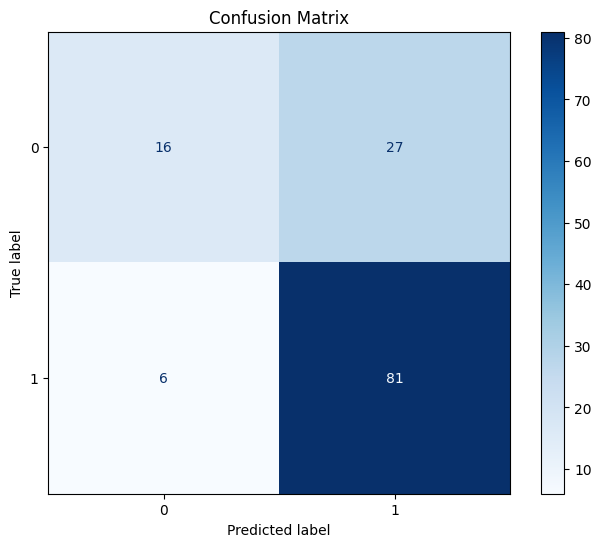

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert predictionDF to pandas DataFrame for scikit-learn
prediction_and_labels = predictionDF.select("prediction", "label").toPandas()

# Compute the confusion matrix
conf_matrix = confusion_matrix(prediction_and_labels['label'], prediction_and_labels['prediction'])

# Define the classes
classes = [str(i) for i in range(len(conf_matrix))]

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [53]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you already have the predictionDF DataFrame and the MulticlassClassificationEvaluator configured
# predictionDF = nnModel.transform(final_test).cache()

# Use MulticlassClassificationEvaluator to compute accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictionDF)

print("Accuracy =  %g" % (accuracy))

# Convert predictionDF to pandas DataFrame for scikit-learn
prediction_and_labels = predictionDF.select("prediction", "label").toPandas()

# Compute precision, recall, and F1-score
precision = precision_score(prediction_and_labels['label'], prediction_and_labels['prediction'], average='weighted')
recall = recall_score(prediction_and_labels['label'], prediction_and_labels['prediction'], average='weighted')
f1 = f1_score(prediction_and_labels['label'], prediction_and_labels['prediction'], average='weighted')

print("Precision = %f" % precision)
print("Recall = %f" % recall)
print("F1 Score = %f" % f1)


Accuracy =  0.746154
Precision = 0.742483
Recall = 0.746154
F1 Score = 0.718817


# Conclusion

  An accuracy of around 75% is reached with our neural network model. It can be observed, when the prediction is wrong, it is usually predicting 2.0 (pneumonia). The reason for this might be the one stated at the beginning, the greater number of pneumonia images than normal ones, which might be mitigated through data augmentation.

Nevertheless, a working neural network classifier was created with DLlib, and trained and evaluated with data contained in Spark dataframes.